In [1]:
import os
import tensorflow as tf
import keras
from keras import models
from keras import layers
from datetime import datetime
from PIL import Image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt


In [2]:
import mlflow 
mlflow.set_experiment('mlflow_class')
mlflow.autolog()

2023/02/20 12:48:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [3]:
# print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

In [4]:
image_size = (255, 255)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'combined_dataset',
    validation_split=0.2,
    subset="training",
    label_mode = 'int',
    labels = 'inferred',
    seed=1337,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'combined_dataset',
    validation_split=0.2,
    subset="validation",
    label_mode = 'int',
    labels = 'inferred',
    seed=1337,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


Found 15351 files belonging to 3 classes.
Using 12281 files for training.
Found 15351 files belonging to 3 classes.
Using 3070 files for validation.


In [5]:
K.clear_session()

In [6]:
imput = (255,255,3)

#Create the model. It is a CNN with maxpooling and dropout

model=models.Sequential()

model.add(layers.Rescaling(scale = 1./255, offset=0.0, input_shape=imput))


model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))
model.add(layers.RandomZoom(0.2))
model.add(layers.RandomContrast(0.2))
# model.add(layers.RandomWidth(0.2))
# model.add(layers.RandomHeight(0.2))


model.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu'))


model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))



# Add flatten layer
model.add(layers.Flatten())

# Add dense/dropout layers + activation functions

model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(3, activation = 'softmax'))



model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 255, 255, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 255, 255, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 251, 251, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 32)      0

In [7]:
folder_date = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

# Callbacks

In [8]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath_model,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_freq="epoch",
save_best_only=True)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose = 1, )

In [10]:
epochs = 20
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)

2023/02/20 12:48:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e7c65ad7a7cf41deb37c7d379640002f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/20
384/384 [==============================] - 167s 401ms/step - loss: 0.5539 - accuracy: 0.7157 - val_loss: 0.6439 - val_accuracy: 0.6215
Epoch 2/20
384/384 [==============================] - 147s 381ms/step - loss: 0.4188 - accuracy: 0.8124 - val_loss: 0.3096 - val_accuracy: 0.8746
Epoch 3/20
384/384 [==============================] - 145s 377ms/step - loss: 0.3632 - accuracy: 0.8472 - val_loss: 0.5952 - val_accuracy: 0.6951
Epoch 4/20
384/384 [==============================] - 145s 376ms/step - loss: 0.3210 - accuracy: 0.8687 - val_loss: 0.2893 - val_accuracy: 0.8782
Epoch 5/20
384/384 [==============================] - 147s 382ms/step - loss: 0.2517 - accuracy: 0.8981 - val_loss: 0.2032 - val_accuracy: 0.9186
Epoch 6/20
384/384 [==============================] - 140s 363ms/step - loss: 0.2314 - accuracy: 0.9080 - val_loss: 0.1684 - val_accuracy: 0.9371
Epoch 7/20
384/384 [==============================] - 125s 325ms/step - loss: 0.2144 - accuracy: 0.9134 - val_loss: 0.2100 -

2023/02/20 13:32:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [11]:
#Guardo el modelo en la última epoch 
model.save( folder_date + '/emodelo_entrenado.h5')


In [12]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [13]:
folder_date + "/accuracy.png"

'2023_02_20-12_48_16_PM/accuracy.png'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


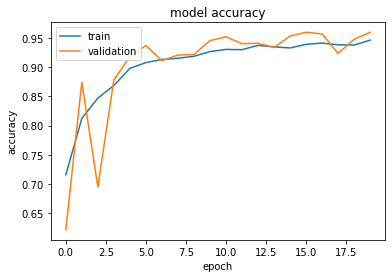

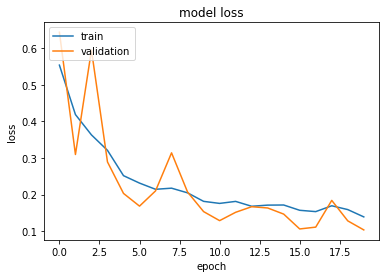

In [14]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(folder_date + "/loss.png")
plt.show()





# This is a section to evaluate the model on te test data

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support


2023/02/20 13:33:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


[0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


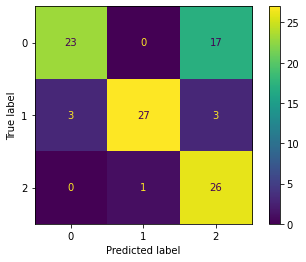

In [16]:

# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []

directory = "test_set"

for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)



    prediction = model.predict(x)
    
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca' in filename:
        true_labels.append(0)
    elif 'scc' in filename or ' e ' in filename:
        true_labels.append(2)
    elif 'lungn' or ' N ' in filename:
        true_labels.append(1)
   
    

    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
precision_recall_fscore_support(true_labels, predicted_labels)


disp.plot()
plt.show()



#Predice mal en las muestras de Henar. Veremos con el nuevo dataset, pero quizá haya que hacer un training con peso Opciones:

Undersample the larger distribution: randomly remove examples from the larger distribution until it matches the size of the smaller one.

Oversample the smaller distribution: randomly duplicate examples from the smaller distribution until it matches the size of the larger one.

Data augmentation: generate new examples from the smaller distribution using techniques like rotation, flipping, or zooming.

Use class weights: adjust the loss function of your CNN to assign higher weights to the smaller distribution so that it receives more emphasis during training.

Fine-tuning: you could use a pre-trained model to initialize the weights and only fine-tune the last few layers to fit the imbalanced data.